In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# 数据提取模块
from  Extract_observation_bt import Extract_observation_bt
from Extract_simulated_bt import Extract_simulated_bt

print(tf.__version__)

2.4.1


In [2]:
Years = ['2007']
train_data = Extract_observation_bt(Years)
train_data.drop(train_data.columns[:9], axis=1, inplace=True)
train_data.drop(train_data.columns[12:], axis=1, inplace=True)
train_data.dropna(inplace=True)

In [3]:
test_data = train_data.sample(frac=0.1, random_state=0)
train_data.drop(test_data.index, inplace=True)

In [4]:
# 标签
SIM_data = Extract_simulated_bt()
# 日期格式转换
def date1(i):
    i1 = str(i)
    if(i1[8:10] == '00'):
        ti = '08'
    elif(i1[8:10] == '12'):
        ti = '20'
    return i1[0:4]+'/'+i1[4:6]+'/'+i1[6:8]+':'+ti
SIM_data.index = [date1(i) for i in SIM_data.index]

In [5]:
for i in train_data.index:
    if(i not in SIM_data.index):
        print(i)
        train_data.drop(i, inplace=True)
print('----------')

for i in test_data.index:
    if(i not in SIM_data.index):
        test_data.drop(i, inplace=True)
        print(i)

2007/07/16:08
2007/07/15:20
2007/12/18:20
----------


In [6]:
test_label = SIM_data.loc[test_data.index].round(1)
train_label = SIM_data.loc[train_data.index].round(1)

In [7]:
print(f'train_data shape is {train_data.shape}')
print(f'train_label shape is {train_label.shape}')
print(f'test_data shape is {test_data.shape}')
print(f'test_label shape is {test_label.shape}')


train_data shape is (337, 12)
train_label shape is (337, 12)
test_data shape is (38, 12)
test_label shape is (38, 12)


In [8]:
# 搭建模型
def build_model():
    My_model = keras.Sequential([
        layers.Dense(len(train_data.keys()), activation='relu', input_shape=[len(train_data.keys())]),
        layers.Dense(47, activation='relu'),
        layers.Dense(len(train_label.keys()))
    ])

    opt = tf.optimizers.Adam(1e-3)
    # tf.train.GradientDescentOptimizer(0.001)
    # tf.keras.optimizers.RMSprop(0.001)
    # tf.optimizers.Adam(1e-3)

    My_model.compile(loss='mse',
                     optimizer=opt,
                     metrics=['mae', 'mse']
                     )
    return My_model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                156       
_________________________________________________________________
dense_1 (Dense)              (None, 47)                611       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                576       
Total params: 1,343
Trainable params: 1,343
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(train_data,
                    train_label,
                    batch_size=32,
                    epochs=500,
                    verbose=0,
                    validation_split=0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [10]:
# 测试数据评估训练结果
loss, mae, mse = model.evaluate(test_data, test_label, verbose=1)

print("MAE: {:5.2f} ".format(mae))
print("MSE: {:5.2f} ".format(mse))
print("LOSS: {:5.2f} ".format(loss))


2/2 [==============================] - 0s 5ms/step - loss: 9.7746 - mae: 2.5126 - mse: 9.7746
MAE:  2.51 
MSE:  9.77 
LOSS:  9.77 


In [11]:
r1 = 0
for i in range(len(test_data)):
    r = np.corrcoef(model.predict(test_data[i:i + 1]), test_label[i:i + 1])
    r1 += r[0, 1]
print('后，相关系数 {:.4}'.format(r1 / len(test_data)))


r1 = 0
for i in range(len(test_data)):
    r = np.corrcoef(test_data[i:i + 1], test_label[i:i + 1])
    r1 += r[0, 1]
print('前，相关系数 {:.4}'.format(r1 / len(test_data)))

后，相关系数 0.9994
前，相关系数 0.7531


In [12]:
def drawing(i):
    predict_data = pd.DataFrame(model.predict(test_data[i:i+1]), columns=test_data.columns)

    plt.plot(test_data.iloc[i,:],test_data.columns, label='test_data')
    plt.plot(test_label.iloc[i,:],test_data.columns, label='test_label')
    plt.plot(predict_data.iloc[0,:], test_data.columns, label='predict_data')
    plt.legend()
    plt.show()

    rld = np.corrcoef(test_label.iloc[i,:], test_data.iloc[i,:])
    rlp = np.corrcoef(test_label.iloc[i,:], predict_data.iloc[0,:])
    print(f'训练样本和训练标签之间的相关系数为 {rld[0,1].round(4)}')
    print(f'训练样本和预测标签之间的相关系数为 {rlp[0,1].round(4)}')
    print('-----------------------------------')

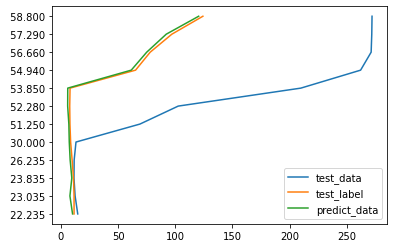

训练样本和训练标签之间的相关系数为 0.8298
训练样本和预测标签之间的相关系数为 0.9998
-----------------------------------


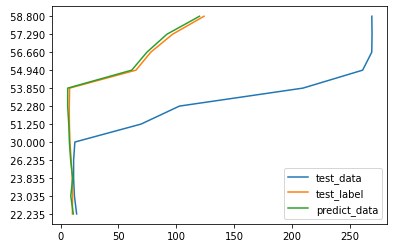

训练样本和训练标签之间的相关系数为 0.8301
训练样本和预测标签之间的相关系数为 0.9998
-----------------------------------


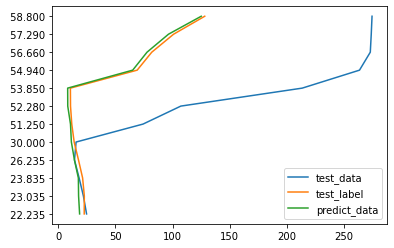

训练样本和训练标签之间的相关系数为 0.7972
训练样本和预测标签之间的相关系数为 0.9997
-----------------------------------


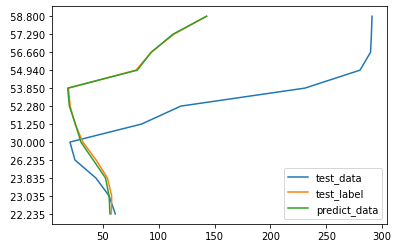

训练样本和训练标签之间的相关系数为 0.6684
训练样本和预测标签之间的相关系数为 0.9996
-----------------------------------


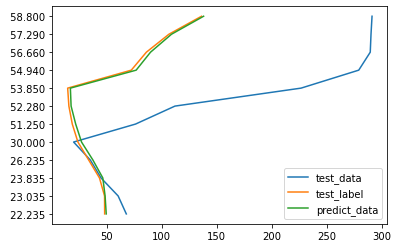

训练样本和训练标签之间的相关系数为 0.7183
训练样本和预测标签之间的相关系数为 0.9996
-----------------------------------


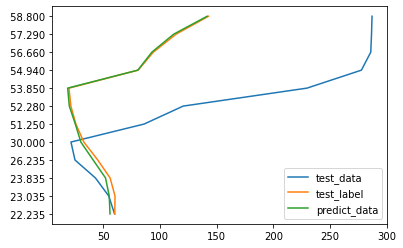

训练样本和训练标签之间的相关系数为 0.6539
训练样本和预测标签之间的相关系数为 0.9991
-----------------------------------


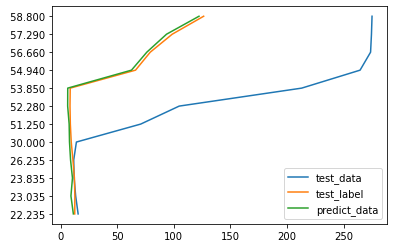

训练样本和训练标签之间的相关系数为 0.8254
训练样本和预测标签之间的相关系数为 0.9999
-----------------------------------


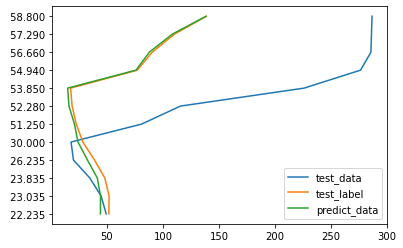

训练样本和训练标签之间的相关系数为 0.6892
训练样本和预测标签之间的相关系数为 0.9982
-----------------------------------


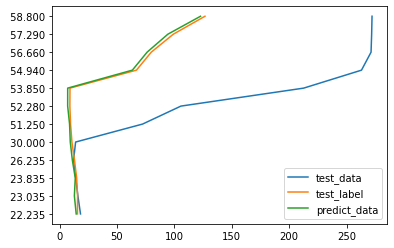

训练样本和训练标签之间的相关系数为 0.8147
训练样本和预测标签之间的相关系数为 0.9999
-----------------------------------


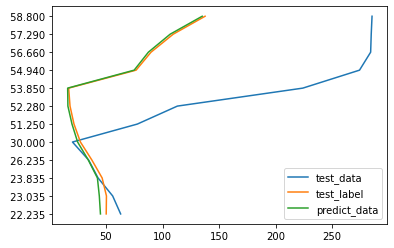

训练样本和训练标签之间的相关系数为 0.7124
训练样本和预测标签之间的相关系数为 0.9992
-----------------------------------


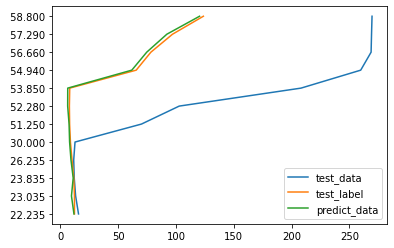

训练样本和训练标签之间的相关系数为 0.828
训练样本和预测标签之间的相关系数为 0.9998
-----------------------------------


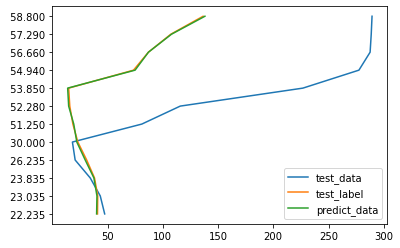

训练样本和训练标签之间的相关系数为 0.7349
训练样本和预测标签之间的相关系数为 0.9999
-----------------------------------


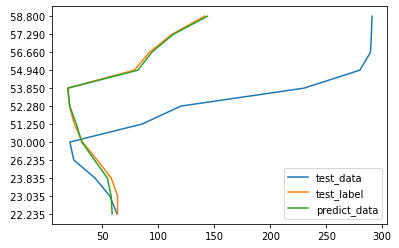

训练样本和训练标签之间的相关系数为 0.6331
训练样本和预测标签之间的相关系数为 0.9974
-----------------------------------


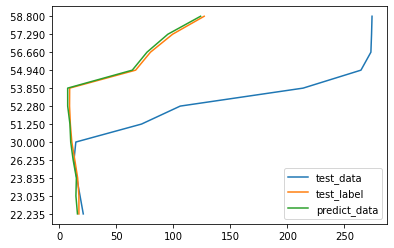

训练样本和训练标签之间的相关系数为 0.8109
训练样本和预测标签之间的相关系数为 0.9999
-----------------------------------


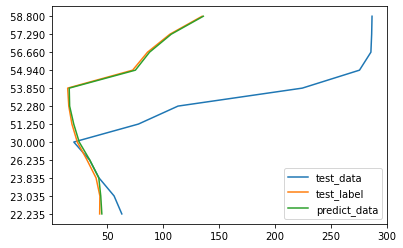

训练样本和训练标签之间的相关系数为 0.7358
训练样本和预测标签之间的相关系数为 0.9999
-----------------------------------


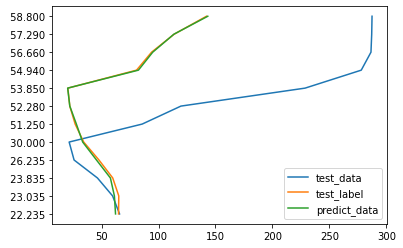

训练样本和训练标签之间的相关系数为 0.6329
训练样本和预测标签之间的相关系数为 0.999
-----------------------------------


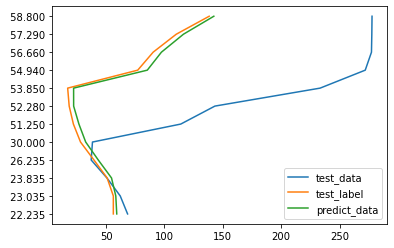

训练样本和训练标签之间的相关系数为 0.626
训练样本和预测标签之间的相关系数为 0.9991
-----------------------------------


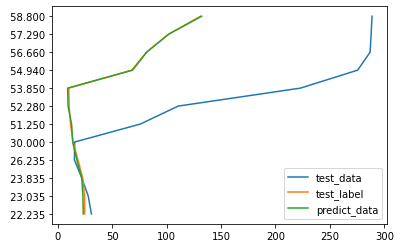

训练样本和训练标签之间的相关系数为 0.7893
训练样本和预测标签之间的相关系数为 0.9998
-----------------------------------


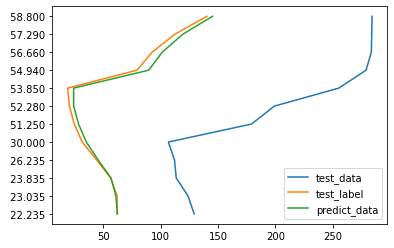

训练样本和训练标签之间的相关系数为 0.5562
训练样本和预测标签之间的相关系数为 0.9967
-----------------------------------


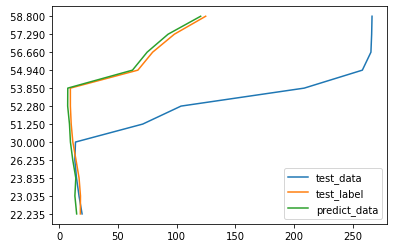

训练样本和训练标签之间的相关系数为 0.8084
训练样本和预测标签之间的相关系数为 0.9998
-----------------------------------


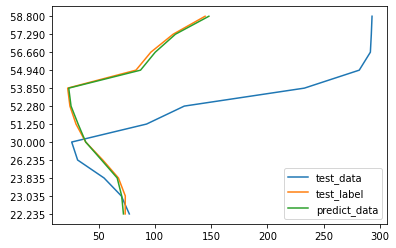

训练样本和训练标签之间的相关系数为 0.594
训练样本和预测标签之间的相关系数为 0.9985
-----------------------------------


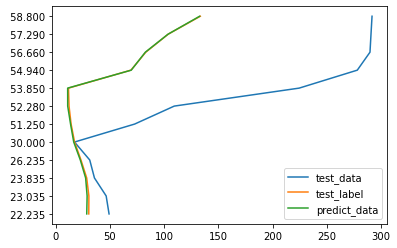

训练样本和训练标签之间的相关系数为 0.7832
训练样本和预测标签之间的相关系数为 0.9999
-----------------------------------


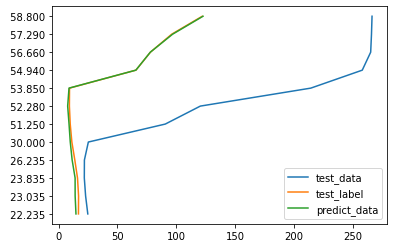

训练样本和训练标签之间的相关系数为 0.7967
训练样本和预测标签之间的相关系数为 0.9999
-----------------------------------


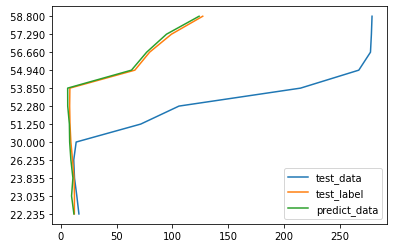

训练样本和训练标签之间的相关系数为 0.8271
训练样本和预测标签之间的相关系数为 0.9999
-----------------------------------


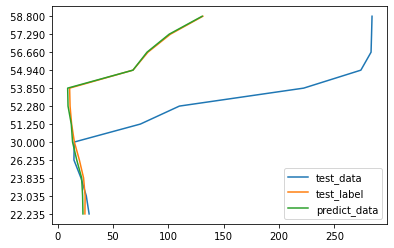

训练样本和训练标签之间的相关系数为 0.7841
训练样本和预测标签之间的相关系数为 0.9999
-----------------------------------


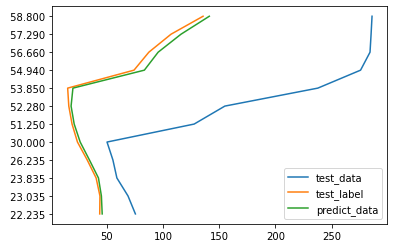

训练样本和训练标签之间的相关系数为 0.6874
训练样本和预测标签之间的相关系数为 0.9987
-----------------------------------


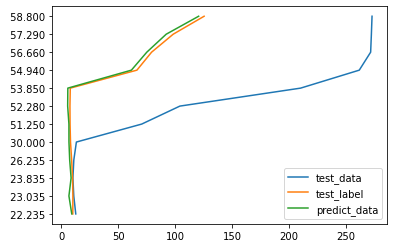

训练样本和训练标签之间的相关系数为 0.834
训练样本和预测标签之间的相关系数为 0.9998
-----------------------------------


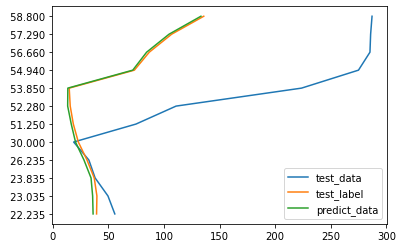

训练样本和训练标签之间的相关系数为 0.7528
训练样本和预测标签之间的相关系数为 0.9998
-----------------------------------


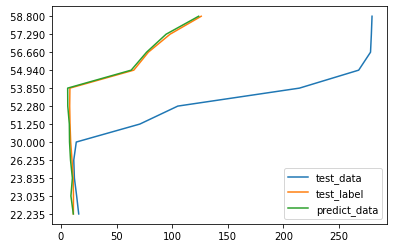

训练样本和训练标签之间的相关系数为 0.8309
训练样本和预测标签之间的相关系数为 0.9998
-----------------------------------


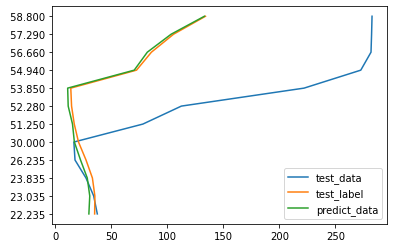

训练样本和训练标签之间的相关系数为 0.7538
训练样本和预测标签之间的相关系数为 0.9996
-----------------------------------


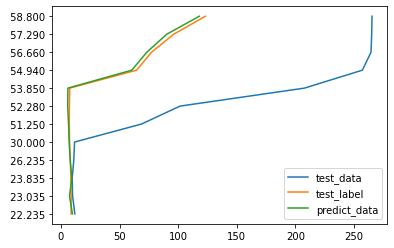

训练样本和训练标签之间的相关系数为 0.8324
训练样本和预测标签之间的相关系数为 0.9997
-----------------------------------


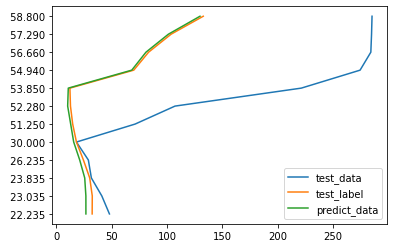

训练样本和训练标签之间的相关系数为 0.7735
训练样本和预测标签之间的相关系数为 0.9994
-----------------------------------


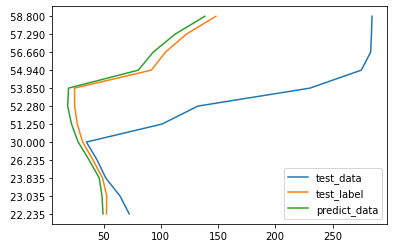

训练样本和训练标签之间的相关系数为 0.7448
训练样本和预测标签之间的相关系数为 0.9987
-----------------------------------


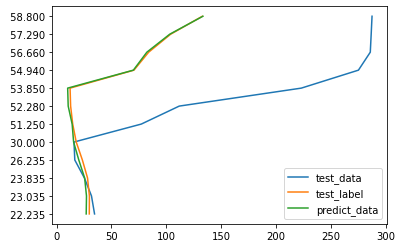

训练样本和训练标签之间的相关系数为 0.7743
训练样本和预测标签之间的相关系数为 0.9998
-----------------------------------


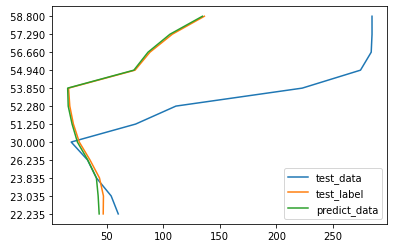

训练样本和训练标签之间的相关系数为 0.7249
训练样本和预测标签之间的相关系数为 0.9996
-----------------------------------


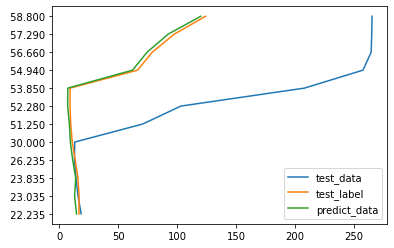

训练样本和训练标签之间的相关系数为 0.8112
训练样本和预测标签之间的相关系数为 0.9998
-----------------------------------


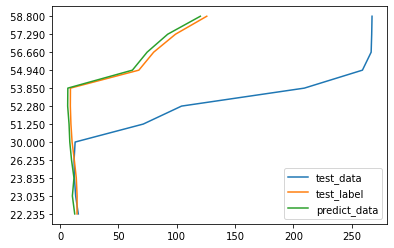

训练样本和训练标签之间的相关系数为 0.8185
训练样本和预测标签之间的相关系数为 0.9998
-----------------------------------


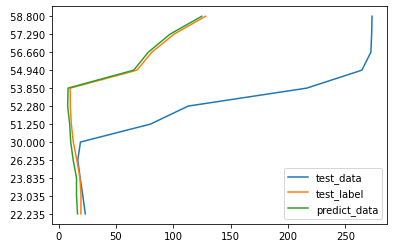

训练样本和训练标签之间的相关系数为 0.7988
训练样本和预测标签之间的相关系数为 0.9999
-----------------------------------


In [13]:
for i in range(len(test_data)):
    drawing(i)

In [14]:
# model.save(r'I:\Data\Personal_Data\graduation_project\Code\Machine_Learning\model')

In [15]:
# new = tf.keras.models.load_model(r'I:\Data\Personal_Data\graduation_project\Code\Machine_Learning\model')
# loss1, mae1, mse1 = new.evaluate(test_data, test_label, verbose=1)
#
# print("MAE: {:5.2f} ".format(mae1))
# print("MSE: {:5.2f} ".format(mse1))
# print("LOSS: {:5.2f} ".format(loss1))